# 3. Chebyshev-Tau spectral method
This notebook demonstrates solving the 1D Burgers equation using the Chebyshev-Tau spectral method, with implementation based on Basdevant1986 and the notes on spectral methods by Prof. Herman Clerx.

We'll go over the following:
- How I apply Chebyshev-Tau method to the 1D Burgers equation
- Some example results from my implementation

A more thorough study of the performance is saved for the comparison between methods.


In [23]:
using Pkg
Pkg.activate("..") # activate BurgersJoint environment
Pkg.instantiate() # install all dependencies if necessary
using BurgersJoint
using BurgersJoint.BurgersEquation
using BurgersJoint.ChebyshevTau
using Plots

  Activating project at `~/Documents/ACFPD/Individual assignment/BurgersJoint`


## Chebyshev-Tau method applied to the 1D Burgers equation

We again consider 1D Burgers equation:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},
$$
defined for $t \in [0, T]$ and $x \in [-1, 1]$ with initial condition $u(0, x) = -\sin(\pi x)$ and periodic boundary conditions.

The velocity field $u(t, x)$ is approximated by a truncated Chebyshev series:
$$
u(t, x) = \sum_{j=0}^{N} a_j(t) T_n(x),
$$
where $a_j$ are the Chebyshev coefficients and $M=N+1$ is the number of Chebyshev modes. $T_n(x)$ are Chebyshev polynomials where we will use $j$ th order Chebyshev polynomials:
$$
T_n(x) = \cos(j \cos^{-1}(x)).
$$
where $x \in [-1, 1]$.
The spatial domain is discretized using Chebyshev-Gauss-Lobatto points
$$
x_j = \cos\left(\frac{j \pi}{N}\right), \quad j = 0, 1, \ldots, N,
$$
which are most closely spaced at the boundaries and least closely spaced in the middle of the domain:


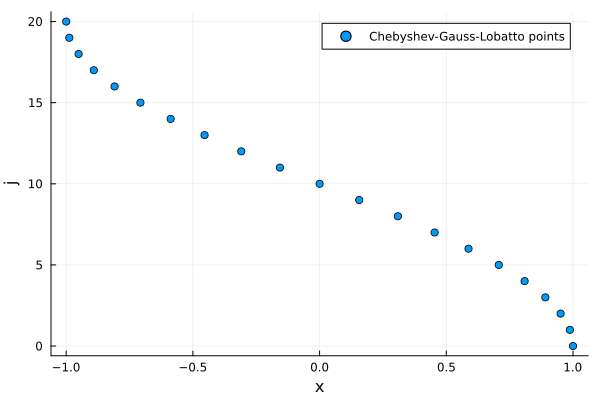

In [24]:
N = 20
j = 0:1:N
x = cos.(pi * (0:N) / N)
plot(x, j, seriestype = :scatter, 
    label = "Chebyshev-Gauss-Lobatto points", 
    xlabel = "x", 
    ylabel = "j")

Over this spatial grid, the velocity field can be written as a vector $\mathbf{u}(t)$ with elements $u_j=u(t, x_j)$ and the coefficients can be combined to a vector $\mathbf{a}(t)$ with elements $a_j(t)$:
$$
\mathbf{u}(t) = \begin{bmatrix}
u_0(t) \\ u_1(t) \\ \vdots \\ u_N(t)
\end{bmatrix},
\quad \mathbf{a}(t)=\begin{bmatrix}
a_0(t) \\ a_1(t) \\ \vdots \\ a_N(t)
\end{bmatrix}
$$
The Chebyshev approximation can then be written on the form
$$
\mathbf{u}(t) = \mathbf{V} \cdot \mathbf{a}(t),
$$
where $\mathbf{V}$ is the Chebyshev Vandermonde matrix:
$$
\mathbf{V} = \begin{bmatrix}
T_0(x_0) & T_1(x_0) & \cdots & T_N(x_0) \\
T_0(x_1) & T_1(x_1) & \cdots & T_N(x_1) \\
\vdots & \vdots & \ddots & \vdots \\
T_0(x_N) & T_1(x_N) & \cdots & T_N(x_N)
\end{bmatrix}
$$
As the Vandermonde matrix is invertible, we can find the Chebyshev coefficients from the inverse relation:
$$
\mathbf{a}(t) = \mathbf{V}^{-1} \mathbf{u}(t)
$$
Basdevant1986 shows that applying the Tau projection method to Burgers' equation leads to a system of ODEs for the Chebyshev coefficients:
$$
\mathbf{c} \odot \frac{d \mathbf{a}}{dt} = \mathbf{L} \cdot \mathbf{a}(t) - \mathbf{N}(t),
$$
where $\odot$ denote elementwise multiplication, $\mathrm{c}$ is a vector of weight factors, $\mathbf{L}$ is the linear operator and $\mathbf{N}$ is the nonlinear operator. Only the first $N-1$ elements should be considered on the left-hand side as the last two coefficients will be found from the following boundary conditions:
$$
\sum_{j=0}^{N} (-1)^j a_j(t) = 0,\quad \sum_{j=0}^{N} a_j(t) = 0.
$$
The weight factors are given by:
$$
\mathbf{c} = \begin{bmatrix}
2 \\ 1 \\ \vdots \\ 1
\end{bmatrix},
$$
The weight factors are used to ensure that the Chebyshev coefficients are normalized correctly.
The linear operator is a $(N-1)\times(N+1)$ matrix with elements (as per Basdevant1986):
$$
L_{lj} = \begin{cases}
\nu\, j\,(j^2 - l^2) & \text{if } j = l+2,\ j+l \text{ even},\\
0 & \text{otherwise}
\end{cases}
$$
The nonlinear term is simply the Chebyshev coefficients of the advection term $u\partial_x u$ of the Burgers equation:
$$
\mathbf{N}(t) = \mathbf{V}^{-1} \cdot \left(\mathbf{u}(t) \odot \frac{d \mathbf{u}}{dt}(t)\right)
$$
The time derivative of the velocity field, $\frac{d \mathbf{u}}{dt}(t)$, can be computed efficiently by:
$$
\frac{d \mathbf{u}}{dt}(t) = \mathbf{D} \cdot \mathbf{a}(t),
$$
where $\mathbf{D}$ is the Chebyshev differentiation matrix. The Chebyshev differentiation matrix is a square matrix of size $(N+1) \times (N+1)$. The elements of the Chebyshev differentiation matrix are given by (as per the Clerx note on spectral methods):
$$
D_{lj} = \begin{cases}
\frac{p_l}{p_j} \frac{(-1)^{l+j}}{x_l - x_j} & \text{if } l \neq j,\\
\frac{-x_j}{2(1-x_j^2)} & \text{if } l = j,\ l \neq 0,\ N,\\
\frac{2N^2+1}{6} & \text{if } l = 0,\ j = 0,\\
\frac{-2N^2+1}{6} & \text{if } l = N,\ j = N,\\
\end{cases}
$$
where $p_l$ and $p_j$ are elements of the weighting factor vector for differentiation:
$$
\mathbf{p} = \begin{bmatrix}
2 \\ 2 \\ 1 \\ \vdots \\ 1
\end{bmatrix},
$$


### ABCN method and its implementation

The ABCN scheme is a time-stepping scheme that is used to solve the system of ODEs for the Chebyshev coefficients. It uses the Adams-Bashforth (AB) for the nonlinear term and the Crank-Nicolson (CN) for the linear term. This scheme yields
$$
\frac{1}{\Delta t}\mathbf{c} \odot \left[\mathbf{a}(t+\Delta t) - \mathbf{a}(t) \right] = \mathcal{L}_\mathrm{CN}(t,t+\Delta t) - \mathcal{N}_\mathrm{AB}(t,t-\Delta t)
$$
Note that all terms here only include the first $N-1$ elements, as the last two should be given by the boundary conditions. I have omitted notating this explicitly as I haven't found a compact way of doing so. The Adam-Bashforth and Crank-Nicolson terms are defined as:
$$
\mathcal{N}_\mathrm{AB}(t,t-\Delta t) = \frac{3}{2}\mathbf{N}(t) - \frac{1}{2}\mathbf{N}(t-\Delta t),
$$
$$
\mathcal{L}_\mathrm{CN}(t,t+\Delta t) = \frac{1}{2}\left(\mathbf{L} \cdot \mathbf{a}(t) + \mathbf{L} \cdot \mathbf{a}(t+\Delta t)\right),
$$
To turn this into an update rule, we first rearrange to get all terms with $\mathbf{a}(t+\Delta t)$ on the left side:
$$
\left(\frac{1}{\Delta t}\mathbf{c}\cdot\mathbf{I} - \frac{1}{2}\mathbf{L}\right) \cdot \mathbf{a}(t+\Delta t) = \left(\frac{1}{\Delta t}\mathbf{c}\cdot\mathbf{I} + \frac{1}{2}\mathbf{L}\right) \cdot \mathbf{a}(t) - \mathcal{N}_\mathrm{AB}(t,t-\Delta t),
$$
we now introduce matric $\mathbf{A}$ and $\mathbf{B}$:
$$
\mathbf{A} = \frac{1}{\Delta t}\mathbf{c}\cdot\mathbf{I} - \frac{1}{2}\mathbf{L},\quad
\mathbf{B} = \frac{1}{\Delta t}\mathbf{c}\cdot\mathbf{I} + \frac{1}{2}\mathbf{L},
$$
so we can express $\mathbf{a}(t+\Delta t)$ by
$$
\mathbf{a}(t+\Delta t) = \mathbf{A}^{-1} \left[\mathbf{B} \cdot \mathbf{a}(t) - \mathcal{N}_\mathrm{AB}(t,t-\Delta t)\right],
$$
which we can make more compact by defining the right-hand side as $\mathbf{b}(t)$:
$$
\mathbf{b}(t) = \mathbf{B} \cdot \mathbf{a}(t) - \mathcal{N}_\mathrm{AB}(t,t-\Delta t),
$$
and the update rule becomes:
$$
\mathbf{a}(t+\Delta t) = \mathbf{A}^{-1} \cdot \mathbf{b}(t),
$$
Currently $\mathbf{b}$ is of size $N-1$ while $\mathbf{A}$ and $\mathbf{B}$ are of size $(N-1)\times(N+1)$ as this only gives us the first $N-1$ elements of $\mathbf{a}(t+\Delta t)$. . The last two elements are given by the boundary conditions (BCs) defined above. We can expand the system to include the BCs by extending $\mathbf{b}$ by two zeros representing the RHS of the BCs and adding two rows to $\mathbf{A}$ representing the sums in the BCs:
$$
\mathbf{b'} = \begin{bmatrix}
\mathbf{b} \\
0 \\ 0
\end{bmatrix},\quad
\mathbf{A'} = \begin{bmatrix}
A_{00} & A_{01} & A_{02} & \cdots & A_{0N} \\
A_{10} & A_{11} & A_{12} & \cdots & A_{1N} \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
A_{N-1,0} & A_{N-1,1} & A_{N-1,2} & \cdots & A_{N-1,N} \\
1 & 1 & 1 & \cdots & 1 \\
1 & -1 & 1 & \cdots & (-1)^N
\end{bmatrix},
$$
With these, the whole system (all $N+1$ coefficients) can be time-stepped by:
$$
\mathbf{a}(t+\Delta t) = \mathbf{A'}^{-1} \cdot \mathbf{b'}.
$$
This is the final update rule for the Chebyshev-Tau method with the ABCN scheme.

### Summary of the algorithm

The algorithm for solving Burgers' equation using the Chebyshev-Tau method with the ABCN scheme can be summarized as follows:

1. Initialize the Chebyshev coefficients $\mathbf{a}(0)$ from the initial condition.
4. Compute the Chebyshev Vandermonde matrix $\mathbf{V}$.
2. Compute the Chebyshev differentiation matrix $\mathbf{D}$ and the linear operator $\mathbf{L}$.
3. Set up weight factors $\mathbf{c}$ and $\mathbf{p}$.
5. Set up matrices $\mathbf{A'}$ and $\mathbf{B}$.
6. Time-stepping loop
    1. Calculate Adams-Bashforth term $\mathcal{N}_\mathrm{AB}(t,t-\Delta t)$ using the Chebyshev coefficients of the velocity field:
        $$
        \mathcal{N}_\mathrm{AB}(t,t-\Delta t) = \frac{3}{2}\mathbf{N}(t) - \frac{1}{2}\mathbf{N}(t-\Delta t),
        $$
        where $\mathbf{N}(t)$ is computed using the Chebyshev coefficients of the velocity field.
    2. Find $\mathbf{b}$ by
        $$
        \mathbf{b}(t) = \mathbf{B} \cdot \mathbf{a}(t) - \mathcal{N}_\mathrm{AB}(t,t-\Delta t),
        $$
        and expand it to $\mathbf{b'}$ by adding two zeros at the end.
    3. Compute the Chebyshev coefficients $\mathbf{a}(t+\Delta t)$ using the update rule:
        $$
        \mathbf{a}(t+\Delta t) = \mathbf{A'}^{-1} \cdot \mathbf{b'},
        $$

Again, I urge you to check the implementation in `ChebyshevTau.jl` in the `src/methods` folder.


## Example results
Let us look at a few example solutions using the Fourier spectral methods. We will use the following parameters unless otherwise specified:
- Domain $x\in[-1,1]$
- Viscosity $\nu = 10^{-2}/\pi$
- Initial condition $u(x,0) = -\sin(x)$
- Number of grid points - 1: $N = 128$ (so 129 grid points)
- Time step $\Delta t = 0.001$
- Total time $T = 4/\pi$

In [25]:
# Parameter choices:
N   = 128
dt = 1e-3
T   = 4/pi
dt_snapshot = 1/pi # time between solution snapshots

x, u_final, snapshot_times, snapshots = solveChebyshevTau(N; dt=dt, T=T, dt_snapshot=dt_snapshot)

([1.0, 0.9996988186962042, 0.9987954562051724, 0.9972904566786902, 0.9951847266721969, 0.99247953459871, 0.989176509964781, 0.9852776423889412, 0.9807852804032304, 0.9757021300385286  …  -0.9757021300385285, -0.9807852804032304, -0.9852776423889412, -0.989176509964781, -0.99247953459871, -0.9951847266721968, -0.9972904566786902, -0.9987954562051724, -0.9996988186962042, -1.0], [-2.6354046594981387e-15, -0.00018864045392157522, -0.0007569380697549682, -0.0016949558013183413, -0.0030258943542484807, -0.004704018989928988, -0.0068012883373729386, -0.009208697512454409, -0.012073797274849382, -0.015198300568250571  …  0.015198297143563659, 0.012073800003114374, 0.00920869543376588, 0.006801289884170193, 0.004704017936023632, 0.003025895045364421, 0.0016949554372446465, 0.0007569382430616017, 0.0001886404366280879, 3.008301329157906e-15], [0.0, 0.318, 0.637, 0.9550000000000001, 1.2730000000000001], [[-0.0, -0.000946188830220334, -0.003784176905133712, -0.008512178594709237, -0.0151270503376

Plot numerical solution versus analytical solution at different times:

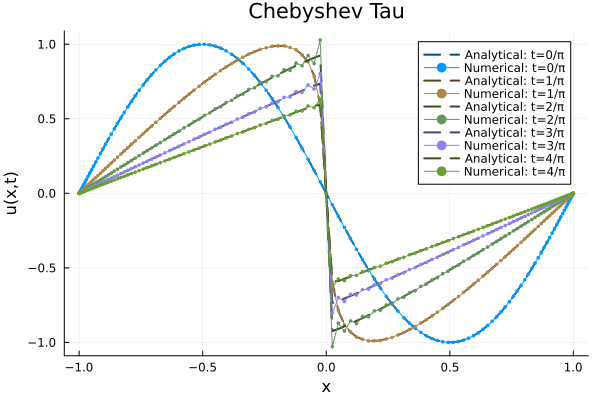

In [26]:
function plot_sol(method_name)
      plt = plot(title="$method_name", xlabel="x", ylabel="u(x,t)")
      pal = palette(:auto, length(snapshot_times))  # get default palette colors

      # Darken the analytical color by reducing brightness
      f = 0.5

      for (i, t) in enumerate(snapshot_times)
            num_color = pal[i]
            analytical_color = RGB(num_color.r * f, num_color.g * f, num_color.b * f)
            plot!(plt, x, analytical_solution(x, t), label="Analytical: t=$(i-1)/π", lw=2, linestyle=:dash, color=analytical_color)
            plot!(plt, x, snapshots[i], label="Numerical: t=$(i-1)/π", lw=1, color=num_color, marker=:circle, markersize=2, markerstrokewidth=0)
      end

      display(plt)
end

plot_sol("Chebyshev Tau")

Compared to the Fourier spectral method (both Galerkin and pseudospectral) for the same number of grid and time points, the Chebyshev-Tau method appears more accurate, with less oscillations in the solution.

#### Different grid spacings

A quick qualitative test of the effect of spatial and temporal grid spacings on the solution:

Solving: 100%[==========================================] Time: 0:00:00


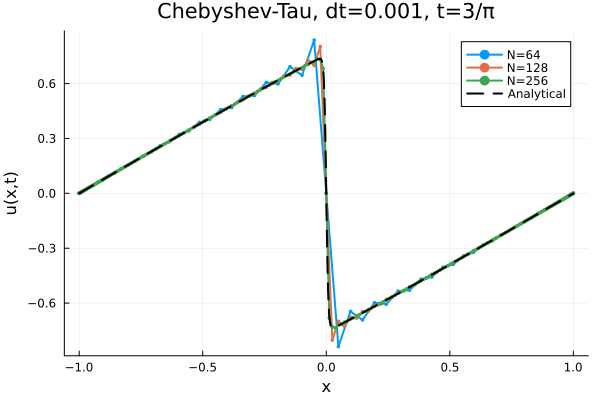

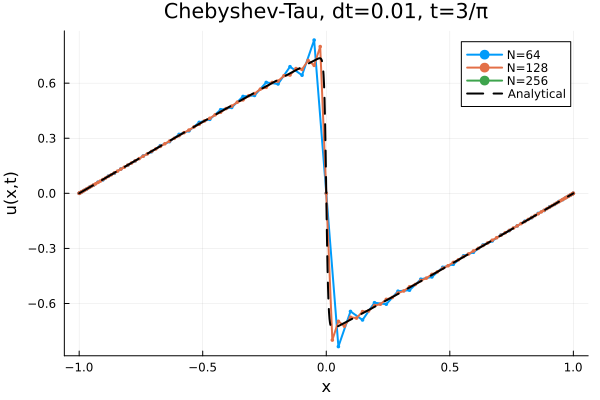

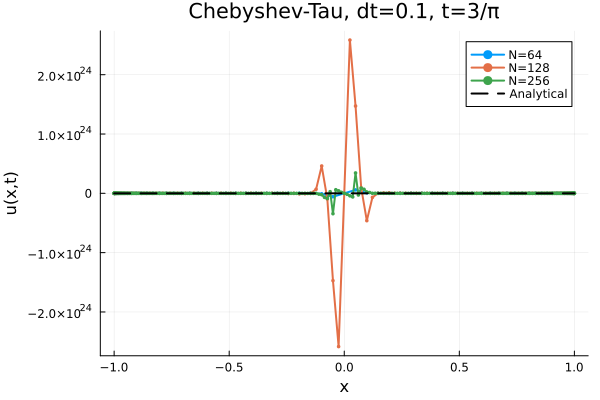

In [33]:
T = 3/pi
N_list = [64, 128, 256]
dt_list = [0.001, 0.01, 0.1]

for dt in dt_list
    plt = plot(title="Chebyshev-Tau, dt=$dt, t=3/π", xlabel="x", ylabel="u(x,t)")
    for N in N_list
        x, u_final, _, _ = solveChebyshevTau(N; dt=dt, T=T)
        plot!(plt, x, u_final, label="N=$N", lw=2, marker=:circle, markersize=2, markerstrokewidth=0)
    end
    x = range(-1, 1, length=1000)
    plot!(plt, x, analytical_solution(x, T), label="Analytical", lw=2, linestyle=:dash,color=:black)
    display(plt)
end

As for Fourier methods, we see that the solution for Chebyshev-Tau is more accurate for smaller spatial grid spacings (higher $N$) and that if the temporal grid spacing is too large, the solution becomes unstable and diverges.

Note that even more accuracy could be acheived with the same grid spacing by only considering half the domain and using the symmetry of the solution: Currently, most of the error is in the middle of the domain, where the gradient is the highest and our Chebyshev-Gauss-Lobatto grid points are most widely spaced. If the solved domain would instead end at the middle of the actual domain, the high-gradient region would be more densely covered by the Chebyshev-Gauss-Lobatto points, and the solution would be more accurate. They implement this in Basdevant1986, but I have not yet done so in my implementation.